In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import librosa
import librosa.display
import numpy as np
import os
import IPython.display as ipd

In [3]:
device = None
dtype = torch.float32
if torch.cuda.is_available():
  device = torch.device('cuda')
else: device = torch.device('cpu')

In [4]:
!git clone https://github.com/soerenab/AudioMNIST.git

Cloning into 'AudioMNIST'...
remote: Enumerating objects: 30119, done.
remote: Total 30119 (delta 0), reused 0 (delta 0), pack-reused 30119
Receiving objects: 100% (30119/30119), 944.54 MiB | 20.79 MiB/s, done.
Resolving deltas: 100% (26/26), done.
Checking out files: 100% (30018/30018), done.


In [5]:
data, sr = librosa.load('AudioMNIST/data/01/0_01_0.wav',mono=True, sr=None)

In [6]:
data.shape

(35877,)

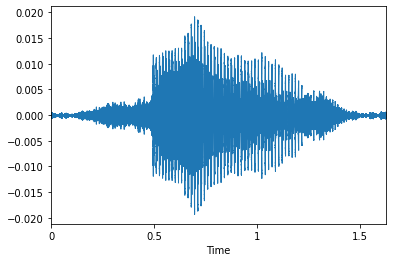

In [7]:
librosa.display.waveplot(data)

In [8]:
X = librosa.stft(data)

Xdb = librosa.amplitude_to_db(abs(librosa.stft(data)))

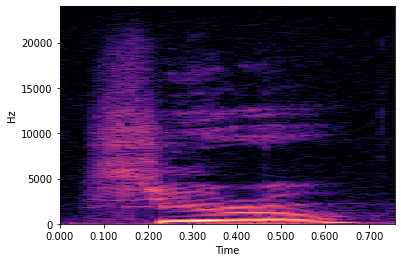

In [9]:
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')

In [10]:
!pip install torchaudio
import torchaudio
import matplotlib.pyplot as plt

     |████████████████████████████████| 1.9 MB 4.2 MB/s 


torch.Size([1, 35877]) <built-in method type of Tensor object at 0x7f2580069820>
48000


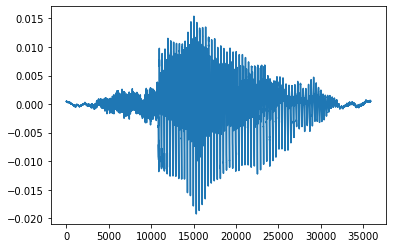

In [11]:
file = 'AudioMNIST/data/01/0_01_0.wav'
audio, sr = torchaudio.load(file)
print(audio.size(), audio.type) 
print(sr)
plt.plot(audio.t().numpy())

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:433: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "
/usr/local/lib/python3.7/dist-packages/torch/functional.py:472: UserWarning: stft will soon require the return_complex parameter be given for real inputs, and will further require that return_complex=True in a future PyTorch release. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:664.)
  normalized, onesided, return_complex)


The slowest run took 73.65 times longer than the fastest. This could mean that an intermediate result is being cached.
1000 loops, best of 5: 823 µs per loop
torch.Size([1, 128, 180])


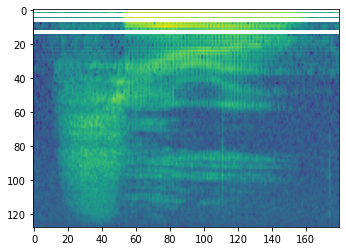

In [12]:
specgram = torchaudio.transforms.MelSpectrogram()(audio)
%timeit torchaudio.transforms.AmplitudeToDB(abs(torch.stft(audio, 4))) #clearly way faster than librosa
print(specgram.size())

plt.figure()
p = plt.imshow(specgram.log2()[0,:,:].detach().numpy())

In [13]:
audio = []
dir = 'AudioMNIST/data/'
#dir = 'free-spoken-digit-dataset/recordings'

for (root,dirs,files) in os.walk(dir):
  for file in files:
    if file.endswith('.wav'):
      path = root+'/'+file
      audio.append(path) #appends [data, sampling rate to audio]
      print(path)
    
      

Streaming output truncated to the last 5000 lines.
AudioMNIST/data/42/8_42_25.wav
AudioMNIST/data/42/7_42_44.wav
AudioMNIST/data/42/8_42_41.wav
AudioMNIST/data/42/2_42_37.wav
AudioMNIST/data/42/1_42_3.wav
AudioMNIST/data/42/9_42_10.wav
AudioMNIST/data/42/1_42_27.wav
AudioMNIST/data/42/4_42_23.wav
AudioMNIST/data/42/6_42_4.wav
AudioMNIST/data/42/9_42_18.wav
AudioMNIST/data/42/1_42_29.wav
AudioMNIST/data/42/9_42_38.wav
AudioMNIST/data/42/1_42_7.wav
AudioMNIST/data/42/2_42_4.wav
AudioMNIST/data/42/4_42_9.wav
AudioMNIST/data/42/2_42_31.wav
AudioMNIST/data/42/8_42_1.wav
AudioMNIST/data/42/9_42_30.wav
AudioMNIST/data/42/3_42_42.wav
AudioMNIST/data/42/3_42_35.wav
AudioMNIST/data/42/9_42_13.wav
AudioMNIST/data/42/9_42_24.wav
AudioMNIST/data/42/0_42_29.wav
AudioMNIST/data/42/9_42_28.wav
AudioMNIST/data/42/2_42_9.wav
AudioMNIST/data/42/3_42_26.wav
AudioMNIST/data/42/6_42_19.wav
AudioMNIST/data/42/8_42_15.wav
AudioMNIST/data/42/6_42_27.wav
AudioMNIST/data/42/2_42_0.wav
AudioMNIST/data/42/5_42_49.

In [14]:
from tensorflow import keras

In [15]:
#audio
#keras.utils.to_categorical

In [16]:
from tensorflow import keras
from sklearn.model_selection import train_test_split
import sys

class DataGenerator:
  def __init__(self, dataset, max_len = 40):
    if dataset == "AudioMNIST":
      path = 'AudioMNIST/data/'
    elif dataset == 'freespeak': path = 'free-spoken-digit-dataset/recordings'
    self.path = path
    self.dataset = dataset;
    self.max_len = max_len
    print(path)

  def process_audio(self, file, root = None):
    '''
    returns audio's mfccs: 
    '''
    max_len = self.max_len;
    if root is None:
      path = os.path.join(self.path, file)
    else:
      path = os.path.join(root, file)
    wave, sr = librosa.load(path, mono=True, sr=None)
    wave = wave[::3]
    mfcc = librosa.feature.mfcc(wave, sr=8000)
    #chroma_stft = librosa.feature.chroma_stft(wave, sr=8000)
    
    pad_width = max_len - mfcc.shape[1]
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    #pad_width_chroma_stft = max_len - chroma_stft.shape[1]
    #chroma_stft = np.pad(chroma_stft, pad_width=((0, 8), (0, pad_width_chroma_stft)), mode='constant')
    return mfcc
    #wave, sr = torchaudio.load_wav(path)
    # shifting to pytorch
    # mel = torchaudio.transform.MelSpectrogram(wave, )
    # pad_width = max_len - mel.shape[1]
    # mel_padded = 

    # return mel_padded

  def __get_data(self):
    '''returns audio files after extracting mfc features and categorical labels'''
    label = []
    data = []
    dir = self.path
    i=0
    
    for (root,dirs,files) in os.walk(dir):
      for file in files:
        i+=1
        if file.endswith('.wav'):
          data.append(self.process_audio(file, root = root))
          
          label.append(file.split('_')[0][0])
          sys.stdout.write("\rDoing thing %i" % i)
          sys.stdout.flush()
    return np.asarray(data), keras.utils.to_categorical(label)

  def get_data(self, test_size = 0.1, val_size = 0.1):
    data, labels = self.__get_data()
    X, X_test, y, y_test = train_test_split(data, labels, test_size=test_size, random_state = 1)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_size, random_state = 2)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [17]:
dataset = DataGenerator('AudioMNIST') 

X_train, X_val, X_test, y_train, y_val, y_test = dataset.get_data(test_size = 0.1, val_size = 0.111)

AudioMNIST/data/
Doing thing 30001

In [18]:
import pickle

In [19]:
X_train.shape

(24003, 20, 40)

In [20]:

data = {
    'X_train': X_train, 'y_train': y_train,
    'X_test': X_test, 'y_test':y_test,
    'X_val': X_val, 'y_val': y_val
}
for key in data.keys():
  mat = data[key]
  pickle.dump( mat, open( "Data/"+key+".pkl", "wb" ) )

In [21]:
#new_data = pickle.load(open('Data/X_train.pkl', 'rb'))
#new_data = np.reshape(new_data, (2000, 20, 20))
#assert (new_data == X_train).all()

In [22]:
!zip -r file.zip Data
from google.colab import files
files.download("file.zip")

  adding: Data/ (stored 0%)
  adding: Data/y_train.pkl (deflated 97%)
  adding: Data/X_train.pkl (deflated 50%)
  adding: Data/y_val.pkl (deflated 97%)
  adding: Data/y_test.pkl (deflated 97%)
  adding: Data/X_val.pkl (deflated 50%)
  adding: Data/X_test.pkl (deflated 50%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
#For loading data from colab
'''
import pickle
data={}
keys = 'X_train, X_val, X_test, y_train, y_val, y_test'.split(', ')
for key in keys:
  path = '/content/drive/My Drive/Stride/audio/Data/' #"Data/"
  mat = pickle.load( open( path +key+".pkl", "rb" ) )
  data.update({key : mat} )

X_train, X_val, X_test, y_train, y_val, y_test = [y for y in data.values()]
'''

'\nimport pickle\ndata={}\nkeys = \'X_train, X_val, X_test, y_train, y_val, y_test\'.split(\', \')\nfor key in keys:\n  path = \'/content/drive/My Drive/Stride/audio/Data/\' #"Data/"\n  mat = pickle.load( open( path +key+".pkl", "rb" ) )\n  data.update({key : mat} )\n\nX_train, X_val, X_test, y_train, y_val, y_test = [y for y in data.values()]\n'

In [24]:
#import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU

#from ann_visualizer.visualize import ann_viz

def get_cnn_model(input_shape, num_classes, d = 0.2):
  model = Sequential()
  #model.add(Input(shape= (20,20,1) ))
  #conv
  model.add(Conv2D(32, kernel_size=3,  input_shape = input_shape)) #18
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #conv
  model.add(Conv2D(64, kernel_size=3)) #16
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #pool
  model.add(Conv2D(32, kernel_size=2, strides = 2)) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  #model.add(Dropout(d))
  #conv
  model.add(Conv2D(64, kernel_size=5, padding = 'same')) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #conv
  model.add(Conv2D(128, kernel_size=3, padding = 'same')) #8
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  #pool
  model.add(Conv2D(128, kernel_size=2, strides = 2, activation='relu')) #2
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  #model.add(Dropout(d))

  model.add(Flatten())
  #2 x FC
  model.add(Dense(256))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(100))
  model.add(BatchNormalization())
  model.add(LeakyReLU(alpha=0.05))
  model.add(Dropout(d))
  model.add(Dense(num_classes, activation='softmax'))

  #model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adadelta(), metrics=['accuracy'])
  
  return model


In [25]:
#model params and minor reshaping
dim = X_train.shape[1]
assert dim == 20
channels =1
X_train = X_train.reshape((X_train.shape[0], dim, 40, channels))
X_val = X_val.reshape((X_val.shape[0], dim, 40, channels))
X_test = X_test.reshape((X_test.shape[0], dim, 40, channels))
input_shape = (dim, 40, 1)
classes = 10

In [26]:
X_train.shape

(24003, 20, 40, 1)

In [27]:
#import keras
#from keras.optimizers import Adam
!nvidia-smi

Wed Aug 18 17:31:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    26W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [28]:
model = get_cnn_model(input_shape, classes) #, 0.4
opt = keras.optimizers.Adam(learning_rate=1e-3)#, decay = 0.95)
# model.compile(optimizer=opt,
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])
model.compile(loss=keras.losses.categorical_crossentropy, optimizer=opt, metrics=['accuracy'])
history = model.fit(X_train, y_train, batch_size=64, epochs=50, 
                    validation_data=(X_val, y_val), verbose = 1)

Epoch 1/50
376/376 [==============================] - 42s 32ms/step - loss: 0.2428 - accuracy: 0.9312 - val_loss: 0.0526 - val_accuracy: 0.9833
Epoch 2/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0619 - accuracy: 0.9835 - val_loss: 0.0174 - val_accuracy: 0.9937
Epoch 3/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0249 - accuracy: 0.9933 - val_loss: 0.0200 - val_accuracy: 0.9937
Epoch 4/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0202 - accuracy: 0.9942 - val_loss: 0.0089 - val_accuracy: 0.9967
Epoch 5/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0145 - accuracy: 0.9959 - val_loss: 0.0062 - val_accuracy: 0.9977
Epoch 6/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0147 - accuracy: 0.9955 - val_loss: 0.0097 - val_accuracy: 0.9973
Epoch 7/50
376/376 [==============================] - 11s 30ms/step - loss: 0.0138 - accuracy: 0.9960 - val_loss: 0.0124 - val_accuracy:

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 18, 38, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 18, 38, 32)        128       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 18, 38, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 38, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 36, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 16, 36, 64)        256       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 36, 64)        0

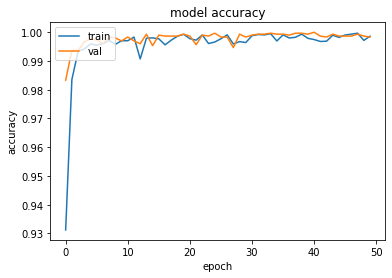

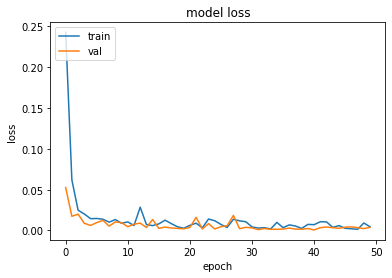

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [32]:
model.evaluate(X_test, y_test, batch_size=64)

47/47 [==============================] - 1s 13ms/step - loss: 0.0014 - accuracy: 0.9997


[0.001439157989807427, 0.999666690826416]

In [33]:
model.save_weights('model_weights.h5')

# Test on given file

In [34]:
data, sr = librosa.load('/content/drive/MyDrive/Stride/VICTIM-AUDIO-ACUITY-TEST.mp3')

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:165: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


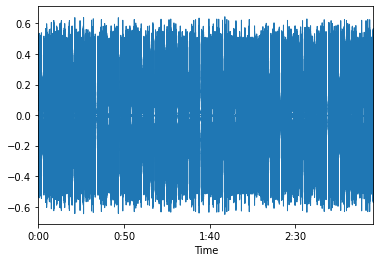

In [35]:
librosa.display.waveplot(data)

In [36]:
data.shape

(4309056,)

In [37]:
file = '/content/drive/MyDrive/Stride/VICTIM-AUDIO-ACUITY-TEST.mp3'
audio, sr = torchaudio.load(file)

In [38]:
audio.shape

torch.Size([1, 4308480])

In [39]:
!pip install pydub
from pydub import AudioSegment
from pydub.silence import split_on_silence

def match_target_amplitude(aChunk, target_dBFS):
    ''' Normalize given audio chunk '''
    change_in_dBFS = target_dBFS - aChunk.dBFS
    return aChunk.apply_gain(change_in_dBFS)

song = AudioSegment.from_mp3(file)

In [40]:
song

In [41]:
chunks = split_on_silence (
    # Use the loaded audio.
    song, 
    # Specify that a silent chunk must be at least 2 seconds or 2000 ms long.
    min_silence_len = 600,
    # Consider a chunk silent if it's quieter than -16 dBFS.
    # (You may want to adjust this parameter.)
    silence_thresh = -40
)

In [42]:
len(chunks)

116

In [43]:
#chunks[1].export("filename.wav", format="wav") #to save as mp3/mp4

In [44]:
chunks[1]

In [53]:
for i in range(len(chunks)):
  chunks[i].export(f"new_data/{i}.wav", format="wav")



In [54]:
!zip -r new_data.zip new_data
from google.colab import files
files.download("new_data.zip")

  adding: new_data/ (stored 0%)
  adding: new_data/51.wav (deflated 12%)
  adding: new_data/93.wav (deflated 12%)
  adding: new_data/16.wav (deflated 9%)
  adding: new_data/97.wav (deflated 17%)
  adding: new_data/48.wav (deflated 12%)
  adding: new_data/38.wav (deflated 11%)
  adding: new_data/65.wav (deflated 22%)
  adding: new_data/41.wav (deflated 24%)
  adding: new_data/35.wav (deflated 8%)
  adding: new_data/49.wav (deflated 9%)
  adding: new_data/79.wav (deflated 21%)
  adding: new_data/13.wav (deflated 12%)
  adding: new_data/17.wav (deflated 41%)
  adding: new_data/26.wav (deflated 24%)
  adding: new_data/7.wav (deflated 12%)
  adding: new_data/39.wav (deflated 8%)
  adding: new_data/60.wav (deflated 12%)
  adding: new_data/84.wav (deflated 37%)
  adding: new_data/21.wav (deflated 26%)
  adding: new_data/81.wav (deflated 22%)
  adding: new_data/76.wav (deflated 46%)
  adding: new_data/15.wav (deflated 22%)
  adding: new_data/9.wav (deflated 41%)
  adding: new_data/57.wav (defl

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [55]:
import sys
class DataGen :

  def __init__(self,dir,num,max_len = 40):
    self.dir = dir
    self.num = num
    self.max_len = 40
    print(dir,num,max_len)


  def process_aud(self,file_path):
    max_len = self.max_len
    wave, sr = librosa.load(file_path,mono=True,sr =None)
    wave = wave[::3]
  

    
    mfcc = librosa.feature.mfcc(wave, sr=8000)

    if mfcc.shape[1] > 80:
      wave, sr = librosa.load(file_path,mono=True,sr =None)
      wave = wave[::10]
      mfcc = librosa.feature.mfcc(wave, sr=8000)

    if mfcc.shape[1] > 40:
      wave, sr = librosa.load(file_path,mono=True,sr =None)
      wave = wave[::7]
      mfcc = librosa.feature.mfcc(wave, sr=8000)

    
    pad_width = max_len - mfcc.shape[1]
    print(pad_width)
    mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
    return mfcc

  def __get_data(self):

    
    data = []
    
    for i in range(self.num):
      file_path = f'/content/{self.dir}/{i}.wav'
      data.append(self.process_aud(file_path))
      
      sys.stdout.write("\rDoing thing %i" % i)
      sys.stdout.flush()
      print(file_path)
    
    return np.asarray(data)

  def get_data(self):

    data = self.__get_data()
    
    return data

In [56]:
dataset_new = DataGen('new_data',116,40)

new_data 116 40


In [57]:
data_audio = dataset_new.get_data()

15
Doing thing 0/content/new_data/0.wav
4
Doing thing 1/content/new_data/1.wav
13
Doing thing 2/content/new_data/2.wav
16
Doing thing 3/content/new_data/3.wav
19
Doing thing 4/content/new_data/4.wav
32
Doing thing 5/content/new_data/5.wav
31
Doing thing 6/content/new_data/6.wav
32
Doing thing 7/content/new_data/7.wav
31
Doing thing 8/content/new_data/8.wav
18
Doing thing 9/content/new_data/9.wav
32
Doing thing 10/content/new_data/10.wav
31
Doing thing 11/content/new_data/11.wav
32
Doing thing 12/content/new_data/12.wav
32
Doing thing 13/content/new_data/13.wav
30
Doing thing 14/content/new_data/14.wav
32
Doing thing 15/content/new_data/15.wav
32
Doing thing 16/content/new_data/16.wav
17
Doing thing 17/content/new_data/17.wav
29
Doing thing 18/content/new_data/18.wav
14
Doing thing 19/content/new_data/19.wav
19
Doing thing 20/content/new_data/20.wav
29
Doing thing 21/content/new_data/21.wav
31
Doing thing 22/content/new_data/22.wav
32
Doing thing 23/content/new_data/23.wav
31
Doing thin

In [58]:
data_audio.shape

(116, 20, 40)

In [59]:
data_audio = data_audio.reshape(data_audio.shape[0],data_audio.shape[1],data_audio.shape[2],1)

In [60]:
final_test_preds = model.predict(data_audio)


In [68]:
final_test_preds[13]

array([2.3576270e-06, 2.3206915e-03, 9.9321733e-06, 7.6661257e-05,
       1.5947453e-03, 9.9412954e-01, 9.8712844e-06, 3.4935718e-05,
       2.0197763e-04, 1.6192989e-03], dtype=float32)

In [62]:
final_test_preds.shape

(116, 10)

In [69]:
chunks[13]

In [66]:
def softmax(x):
    
    max = np.max(x,axis=0,keepdims=True) #returns max of each row and keeps same dims
    e_x = np.exp(x - max) #subtracts each row with its max value
    sum = np.sum(e_x,axis=0,keepdims=True) #returns sum of each row and keeps same dims
    f_x = e_x / sum 
    return f_x

In [70]:
softmax(final_test_preds[13])

array([0.08541009, 0.08560833, 0.08541073, 0.08541644, 0.0855462 ,
       0.2308092 , 0.08541073, 0.08541287, 0.08542714, 0.0855483 ],
      dtype=float32)

In [87]:
dat,srr = librosa.load('/content/AudioMNIST/data/03/0_03_0.wav')
#dat,srr = librosa.load('/content/new_data/11.wav')
dat = dat[::3]
dat.shape

(4793,)

In [88]:
mfccX = librosa.feature.mfcc(dat, sr=8000)

In [89]:
mfccX.shape

(20, 10)

In [90]:
#AudioSegment.from_wav('/content/new_data/11.wav')
AudioSegment.from_wav('/content/AudioMNIST/data/03/0_03_0.wav')

In [91]:
pad_widthX = 40 - mfccX.shape[1]
mfccX = np.pad(mfccX, pad_width=((0, 0), (0, pad_widthX)), mode='constant')

In [92]:
mfccX = mfccX.reshape(1,20,40,1)

In [93]:
testp  = model.predict(mfccX)

In [94]:
testp.shape

(1, 10)

In [95]:
softmax(testp[0])

array([0.0868756 , 0.08718883, 0.08687809, 0.08687803, 0.20497279,
       0.09962331, 0.08688328, 0.08687945, 0.08694512, 0.0868756 ],
      dtype=float32)